# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import corner

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
ScaleFactor = 30 # Integer, reduces x ScaleFactor the number of measurements used to do the MCMC

In [3]:
c = 299792.458  # km/s

def GetDopplerShift(f_c, f_m):
    DS = (f_m - f_c)/f_c
    return DS
    
def get_v_radial(f_c, f_m):
    v_r = c * GetDopplerShift(f_c, f_m)
    return v_r

In [4]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [5]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [6]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [7]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


# Get Doppler Shift data from F_c and F_m

In [8]:
f_c = obj['data'][0]['channel_f_center']

In [9]:
tau = []
DS = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_DS   = []
    
    
    for s in range(len(stream)):
        if (s % ScaleFactor == 0):
            aux_tau.append( float(stream[s]['time_system']))
            aux_DS.append( GetDopplerShift(f_c, float(stream[s]['f']) ))

    print("Stream length: {}".format(len(aux_DS)))
    tau.append(aux_tau)
    DS.append(aux_DS)

Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 13
Sat ID: 1
Stream length: 14


In [10]:
M = 0

for i in range(N):
    print(len(tau[i]))
    M += len(tau[i])
    
print('Total number of Measurements M = {}'.format(M))

14
14
13
14
Total number of Measurements M = 55


### Doppler Shift measured by Ground Stations

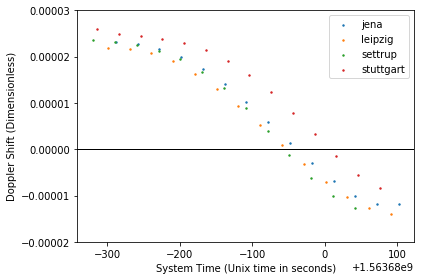

In [11]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], DS[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

In [12]:
Doppler_Uncertainty = 10**(-7)

### Calculating GS positions and velocities in the GeoCentric Reference System

In [13]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [14]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [15]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
%%In this case around 8 minutes per four stations (~1600 observations)

In [16]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-26 16:22:42.211413
iteration 0 ends at time 2019-08-26 16:22:47.919221
iteration 1 starts at time 2019-08-26 16:22:47.919702
iteration 1 ends at time 2019-08-26 16:22:52.507621
iteration 2 starts at time 2019-08-26 16:22:52.508249
iteration 2 ends at time 2019-08-26 16:22:57.045703
iteration 3 starts at time 2019-08-26 16:22:57.046274
iteration 3 ends at time 2019-08-26 16:23:02.504470


### How it looks:

In [17]:
GS_gcrs_positions[0][:3]

[<CartesianRepresentation (x, y, z) in m
     (4035733.15241229, 145414.66606224, 4920400.42424484)>,
 <CartesianRepresentation (x, y, z) in m
     (4035405.21181083, 154222.88050481, 4920401.1947472)>,
 <CartesianRepresentation (x, y, z) in m
     (4035058.0028907, 163030.35634386, 4920402.00126166)>]

In [18]:
GS_gcrs_velocities[0][:3]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61021292, 293.61897176, 0.02508017)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-11.25240431, 293.59512407, 0.02629072)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-11.89470239, 293.56979662, 0.02749369)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [19]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

14 14 14
14 14 14
13 13 13
14 14 14


### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [20]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(1):  ## range(1) takes only the first station, not the average of positions
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [21]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.15241229, 145414.66606224, 4920400.42424484)>

In [22]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(GS_av)

(4035733.152412287, 145414.66606223976, 4920400.4242448425)


### Generate the initial positions of Random Walkers

In [23]:
def random_a():
    return (Earth.R + np.random.normal(500000, 200000)*u.m).value

def random_ecc():
    return np.random.rand()*0.1

def random_inc():
    return np.random.normal(45, 30)

def random_raan():
    return np.random.rand()*360

def random_argp():
    return np.random.rand()*360

def random_nu():
    return np.random.rand()*360

# Orbit generated from Classical Parameters

In [24]:
nwalkers = 100
ndim = 6
MCMC_steps = 50

In [25]:
P0 = []

for i in range(nwalkers):
    aux = np.array([random_a(), random_ecc(), random_inc(), 
                    random_raan(), random_argp(), random_nu()])
    P0.append(aux)
    
P0 = np.array(P0)

# Likelihood

In [26]:
c = 299792.458 * u.km / u.s

def redshift(f_0, Vradial ):
    
    return f_0 * (1 + Vradial / c)

In [27]:
type(tau_astropytime[0][0])

astropy.time.core.Time

In [28]:
TestOrbit = Orbit.from_classical(Earth, 
                               P0[0][0]*u.m,
                               P0[0][1]*u.one,
                               P0[0][2]*u.deg,
                               P0[0][3]*u.deg,
                               P0[0][4]*u.deg,
                               P0[0][5]*u.deg,
                               epoch=tau_astropytime[0][0] )

In [29]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

In [30]:
def lnprob( param ):
    """
    param = [a, ecc, inc, raan, argp, nu]
    """
    a, ecc, inc, raan, argp, nu = param
    
    ### Limit the parameter space ###
    
    if a < Earth.R.value + 100000:
        return -np.inf
    
    if (ecc < 0) or (ecc > 1) :
        return -np.inf
    
    if (inc < 0) or (inc > 180):
        return -np.inf
    
    if abs(raan) > 360:
        return -np.inf
    
    if abs(nu) > 180:
        return -np.inf
    
    a    =   a  * u.m
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    tau_0 = tau_astropytime[0][0]

    myOrbit = Orbit.from_classical(Earth, 
                                 a=a, ecc=ecc, inc=inc, 
                                 raan=raan, argp=argp, nu=nu, epoch=tau_0)
    

    chi2 = 0
    for i in range(N):
        for j in range(len(tau_astropytime[i])):
            chi_aux = 0
            
            t_prime = tau_astropytime[i][j]
            DeltaT = t_prime - tau_0
            
            orbit_at_t_prime = myOrbit.propagate(DeltaT)
                        
            r_sat = orbit_at_t_prime.state.r
            v_sat = orbit_at_t_prime.state.v
            
            r_gs  = GS_gcrs_positions[i][j].get_xyz()
            v_gs  = GS_gcrs_velocities[i][j].get_xyz()

            
            r      = r_sat - r_gs
            r_unit =  r / norm(r)
            v      = v_sat - v_gs
            
            ds_mcmc = v.dot(-r_unit)/c
            ds_obs  = DS[i][j]
            
            chi_aux = -0.5 * ((ds_mcmc - ds_obs) / Doppler_Uncertainty )**2 / (M - 6)
            
            #print( 'Chi2 {:03.8f} measured {:03.8f} mcmcm {:03.8f} '.format(chi_aux, ds_obs, ds_mcmc) )
            
            
            chi2 += chi_aux

    print("Chi2 = {}".format(chi2))
    return chi2

In [31]:
for i in range(nwalkers):
    lnprob(P0[i])

Chi2 = -11162.92824756741
Chi2 = -23173.296674678393
Chi2 = -12705.880777347405
Chi2 = -11452.765530636345
Chi2 = -26327.977083976853
Chi2 = -12083.701432073554
Chi2 = -13109.279026670803
Chi2 = -11018.531367213553
Chi2 = -11748.72935491705
Chi2 = -12537.574873281008
Chi2 = -47795.961515789044
Chi2 = -11634.214378311313
Chi2 = -14773.300665777168
Chi2 = -18594.058806236953
Chi2 = -44200.68001870912
Chi2 = -17442.96296098598
Chi2 = -23860.26581333732
Chi2 = -9102.478669761462
Chi2 = -24660.999088109987
Chi2 = -67658.20176978907
Chi2 = -9635.47054416893
Chi2 = -11908.97496108713
Chi2 = -18353.052069066554
Chi2 = -26739.600241438373
Chi2 = -12979.669910544579
Chi2 = -59203.43562779027
Chi2 = -20167.95562800458
Chi2 = -21885.141192938358
Chi2 = -11299.808831915407
Chi2 = -14984.181966503316
Chi2 = -13494.20949109115
Chi2 = -28055.62393477604
Chi2 = -17281.66323936638
Chi2 = -21175.89617829583
Chi2 = -13773.62666794086
Chi2 = -12581.86834878523
Chi2 = -11563.532253141464
Chi2 = -12418.19717

In [32]:
emcee.__version__

'2.2.1'

In [33]:
t_mcmc_start = t.Time.now()

print(" MCMC running with {} walkers, {} Steps. Starts at t={}".format(nwalkers, MCMC_steps, t_mcmc_start))

 MCMC running with 100 walkers, 50 Steps. Starts at t=2019-08-26 16:23:51.763965


In [34]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

pos, prob, state = sampler.run_mcmc(P0, MCMC_steps)

Chi2 = -11162.92824756741
Chi2 = -11452.765530636345
Chi2 = -13109.279026670803
Chi2 = -47795.961515789044
Chi2 = -23173.296674678393
Chi2 = -26327.977083976853
Chi2 = -11018.531367213553
Chi2 = -11634.214378311313
Chi2 = -12705.880777347405
Chi2 = -12083.701432073554
Chi2 = -11748.72935491705
Chi2 = -14773.300665777168
Chi2 = -18594.058806236953
Chi2 = -24660.999088109987
Chi2 = -12537.574873281008
Chi2 = -18353.052069066554
Chi2 = -44200.68001870912
Chi2 = -67658.20176978907
Chi2 = -12979.669910544579
Chi2 = -26739.600241438373
Chi2 = -9635.47054416893
Chi2 = -17442.96296098598
Chi2 = -59203.43562779027
Chi2 = -20167.95562800458
Chi2 = -11908.97496108713
Chi2 = -23860.26581333732
Chi2 = -13494.20949109115
Chi2 = -21885.141192938358
Chi2 = -28055.62393477604
Chi2 = -9102.478669761462
Chi2 = -21175.89617829583
Chi2 = -11299.808831915407
Chi2 = -17281.66323936638
Chi2 = -12418.197170741172
Chi2 = -13773.62666794086
Chi2 = -8088.50039300852
Chi2 = -14984.181966503316
Chi2 = -31349.552566

/home/filipo/anaconda3/envs/env_name/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning:

invalid value encountered in subtract

/home/filipo/anaconda3/envs/env_name/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning:

invalid value encountered in greater



Chi2 = -21283.663552398084
Chi2 = -10732.889829611166
Chi2 = -14885.70493657373
Chi2 = -21476.547684394176
Chi2 = -15287.966736281713
Chi2 = -11870.507800211226
Chi2 = -35919.663236206594
Chi2 = -20905.334524997015
Chi2 = -17305.312582440318
Chi2 = -12890.09621027468
Chi2 = -32333.51162773117
Chi2 = -36917.36110353846
Chi2 = -12825.788414467333
Chi2 = -11838.149537064932
Chi2 = -26003.30196183433
Chi2 = -19375.494927718955
Chi2 = -12383.056706087607
Chi2 = -45152.26094195707
Chi2 = -7153.017182586035
Chi2 = -26927.259278567803
Chi2 = -23326.38776760456
Chi2 = -11253.342888572051
Chi2 = -11270.279222944448
Chi2 = -13099.013595541513
Chi2 = -35829.37561485882
Chi2 = -15944.819304584113
Chi2 = -43662.978484607134
Chi2 = -17204.219842514987
Chi2 = -13120.372932839755
Chi2 = -11059.261187085367
Chi2 = -9939.048252171373
Chi2 = -12190.598988353893
Chi2 = -34225.19848498584
Chi2 = -10250.414629312438
Chi2 = -17618.60715738012
Chi2 = -9448.05385098538
Chi2 = -24139.956648179526
Chi2 = -6642.40

Chi2 = -22347.229109981112
Chi2 = -12656.895568153437
Chi2 = -11367.118588652025
Chi2 = -12072.66866435361
Chi2 = -16115.176270205187
Chi2 = -8949.406764723186
Chi2 = -12263.123473301486
Chi2 = -12013.251934553813
Chi2 = -36909.13338188498
Chi2 = -45717.240599508295
Chi2 = -34621.61062460413
Chi2 = -9289.948969560453
Chi2 = -17075.39296855466
Chi2 = -36376.119307610476
Chi2 = -18403.01475720257
Chi2 = -11522.205682153884
Chi2 = -12302.075542973775
Chi2 = -11323.693042769442
Chi2 = -11049.7486820397
Chi2 = -14722.75528955954
Chi2 = -18489.821856256644
Chi2 = -10710.458962447285
Chi2 = -11694.21659214766
Chi2 = -11764.58744509361
Chi2 = -14344.65374741032
Chi2 = -10272.671390721202
Chi2 = -15203.713130973638
Chi2 = -15212.81937809361
Chi2 = -7076.382725585709
Chi2 = -9052.602911767286
Chi2 = -12815.660378979386
Chi2 = -3180.5454102187823
Chi2 = -8766.357723886582
Chi2 = -11355.225741366054
Chi2 = -12386.46445339622
Chi2 = -8285.333536582457
Chi2 = -13284.719558034569
Chi2 = -10709.062861

Chi2 = -14250.635464966592
Chi2 = -11309.922548216828
Chi2 = -12698.803133496482
Chi2 = -7835.2427796859365
Chi2 = -11306.663314224788
Chi2 = -10891.417335254133
Chi2 = -16225.52343141967
Chi2 = -10364.015980345719
Chi2 = -19188.292949284732
Chi2 = -13533.988367532682
Chi2 = -10398.738113657038
Chi2 = -26683.998780241345
Chi2 = -21555.240123519037
Chi2 = -17998.721289770787
Chi2 = -5784.308694181069
Chi2 = -15863.576304188902
Chi2 = -16952.844209226907
Chi2 = -13056.564071249231
Chi2 = -19589.841799245583
Chi2 = -8575.946387658809
Chi2 = -7837.720480185383
Chi2 = -7241.229540738761
Chi2 = -14564.639001984317
Chi2 = -13690.337818834649
Chi2 = -7663.485028794629
Chi2 = -14374.43274161607
Chi2 = -7909.692400539433
Chi2 = -7978.428439726644
Chi2 = -7289.625787513965
Chi2 = -18997.188840641214
Chi2 = -9730.762171577826
Chi2 = -9914.87171918204
Chi2 = -11207.604719798952
Chi2 = -23291.51204150832
Chi2 = -16850.536545455478
Chi2 = -9435.713470448105
Chi2 = -8398.49662710905
Chi2 = -32256.2857

Chi2 = -19797.03249925728
Chi2 = -11135.899038061327
Chi2 = -46170.338199978454
Chi2 = -15308.707670696367
Chi2 = -10101.204993008436
Chi2 = -33952.691429690996
Chi2 = -11235.56247800881
Chi2 = -11237.823735555483
Chi2 = -18854.9796381705
Chi2 = -18624.037581195036
Chi2 = -6755.81483030309
Chi2 = -7449.264588050725
Chi2 = -7560.987939686569
Chi2 = -9326.23196635381
Chi2 = -8555.353552021894
Chi2 = -10856.469794740566
Chi2 = -11450.263525393008
Chi2 = -8141.836290153069
Chi2 = -13262.456558678645
Chi2 = -14306.104724408857
Chi2 = -8128.527235237782
Chi2 = -11287.24439179354
Chi2 = -27989.26566433827
Chi2 = -12449.285269878063
Chi2 = -10127.247250231865
Chi2 = -19794.192669777774
Chi2 = -11845.492883323097
Chi2 = -10746.14328414013
Chi2 = -11655.39692208043
Chi2 = -46990.86603643592
Chi2 = -10938.431666252396
Chi2 = -9816.858691510519
Chi2 = -24605.457125907058
Chi2 = -10395.044813513301
Chi2 = -9928.541644986606
Chi2 = -12457.68293604067
Chi2 = -24754.11306556235
Chi2 = -5778.7643312522

Chi2 = -9376.977322538281
Chi2 = -15097.472075468198
Chi2 = -6083.175275523761
Chi2 = -10994.394952582892
Chi2 = -10393.525403423493
Chi2 = -11195.060093236045
Chi2 = -12359.06600168302
Chi2 = -7987.231843665911
Chi2 = -16060.913786750134
Chi2 = -7697.657915550354
Chi2 = -11791.831862030724
Chi2 = -11155.647653413398
Chi2 = -13238.63107206303
Chi2 = -7064.758437139794
Chi2 = -8861.230201241808
Chi2 = -8474.988672506843
Chi2 = -9047.45892608445
Chi2 = -9323.134909919512
Chi2 = -27135.248686954692
Chi2 = -18781.211908546775
Chi2 = -9112.195111814844
Chi2 = -45270.07127277908
Chi2 = -52579.460960739365
Chi2 = -9067.229124007812
Chi2 = -7813.418496938406
Chi2 = -16208.679942036679
Chi2 = -28004.048408949122
Chi2 = -33363.30999177876
Chi2 = -45860.65973641362
Chi2 = -7535.281888024271
Chi2 = -6591.563709001363
Chi2 = -20604.117208513482
Chi2 = -51448.95499203697
Chi2 = -30656.79349425767
Chi2 = -16724.46334778485
Chi2 = -16244.498529719862
Chi2 = -11381.260825441526
Chi2 = -11127.0734585400

Chi2 = -26613.99076816278
Chi2 = -8503.78268267263
Chi2 = -51054.943851819866
Chi2 = -8511.514689512253
Chi2 = -11474.899395040946
Chi2 = -11295.553323784672
Chi2 = -11734.373713617386
Chi2 = -12090.679863137833
Chi2 = -13417.27886768705
Chi2 = -10945.32198936452
Chi2 = -18302.52352066152
Chi2 = -12478.021852661335
Chi2 = -29301.24486526737
Chi2 = -10632.469381570525
Chi2 = -42793.213207275236
Chi2 = -7398.141619360062
Chi2 = -9682.223443869067
Chi2 = -20623.77508682614
Chi2 = -11104.536443346638
Chi2 = -11321.19072651083
Chi2 = -8381.060302295866
Chi2 = -6218.322966144381
Chi2 = -11007.784153649174
Chi2 = -11272.650750338864
Chi2 = -10633.56053714194
Chi2 = -8923.676673243282
Chi2 = -8975.1819033091
Chi2 = -18254.226895332573
Chi2 = -9590.578215133792
Chi2 = -9458.382260524395
Chi2 = -10976.429038790598
Chi2 = -6481.324288208452
Chi2 = -12009.826060833813
Chi2 = -13432.119687461494
Chi2 = -11484.681295309272
Chi2 = -6662.9136643273305
Chi2 = -20455.975033132072
Chi2 = -42485.012083839

Chi2 = -45034.76055062826
Chi2 = -51136.708082192774
Chi2 = -11154.295292927161
Chi2 = -12350.79753089176
Chi2 = -11499.19771880136
Chi2 = -10980.675954139682
Chi2 = -11016.850693486023
Chi2 = -16181.70436124573
Chi2 = -19640.909414970916
Chi2 = -10437.543384194869
Chi2 = -18552.94177722343
Chi2 = -8452.772091914878
Chi2 = -7625.992808544614
Chi2 = -11259.531957205545
Chi2 = -7612.915987172341
Chi2 = -13865.894879306223
Chi2 = -7726.058761190934
Chi2 = -9786.22782706642
Chi2 = -6443.003742211796
Chi2 = -48534.361196535996
Chi2 = -14812.149105760858
Chi2 = -11820.561187717913
Chi2 = -21962.313158321685
Chi2 = -40109.793786530776
Chi2 = -9805.50566737349
Chi2 = -10408.466863262993
Chi2 = -25716.104423940254
Chi2 = -16771.450290625464
Chi2 = -3381.4071265178686
Chi2 = -15493.382831631383
Chi2 = -12008.463177137703
Chi2 = -14025.985915534458
Chi2 = -11697.324995586921
Chi2 = -11226.015443821812
Chi2 = -12308.697777624504
Chi2 = -7990.878894246741
Chi2 = -2913.6249888062457
Chi2 = -8883.196

Chi2 = -14156.045423123795
Chi2 = -11487.192633892433
Chi2 = -3547.069037746157
Chi2 = -9875.451882640218
Chi2 = -23206.88729723472
Chi2 = -13389.828180023982
Chi2 = -1130.645642012695
Chi2 = -7950.266165258485
Chi2 = -26208.100378275212
Chi2 = -8964.159082360628
Chi2 = -11709.438418081798
Chi2 = -8647.399006412183
Chi2 = -9751.362427550606
Chi2 = -57273.7117771793
Chi2 = -14318.403395375879
Chi2 = -61867.39851690987
Chi2 = -10577.322923233793
Chi2 = -9091.321478873839
Chi2 = -11754.180721560027
Chi2 = -6057.009491769247
Chi2 = -18371.762407951188
Chi2 = -5013.281543223052
Chi2 = -8121.754911402529
Chi2 = -11498.67070778457
Chi2 = -30195.838687641735
Chi2 = -3386.664169963082
Chi2 = -10363.02408564836
Chi2 = -8572.760887532164
Chi2 = -28146.184873142167
Chi2 = -15048.495501097274
Chi2 = -10637.79231777768
Chi2 = -10874.86522911922
Chi2 = -29773.279146261535
Chi2 = -8711.459277350006
Chi2 = -8294.251699077202
Chi2 = -9223.042017101185
Chi2 = -6991.166872603255
Chi2 = -10236.890830565511

Chi2 = -6370.900483685418
Chi2 = -12864.188632017325
Chi2 = -9930.93869386083
Chi2 = -12635.115263849337
Chi2 = -59091.08511403532
Chi2 = -34467.16392802259
Chi2 = -33093.19287427492
Chi2 = -34583.07792166725
Chi2 = -10110.20475302296
Chi2 = -4662.906813182724
Chi2 = -11553.839616909023
Chi2 = -40725.90915849404
Chi2 = -23635.653925847633
Chi2 = -35118.043488636846
Chi2 = -18067.944207298402
Chi2 = -8715.136504747417
Chi2 = -7438.804119530164
Chi2 = -43544.21421147989
Chi2 = -12154.763986986645
Chi2 = -11758.412436069879
Chi2 = -11882.57855277029
Chi2 = -4415.136537714632
Chi2 = -6653.13186612876
Chi2 = -55192.05053981064
Chi2 = -26199.21623007553
Chi2 = -45992.37000539383
Chi2 = -5971.808066816753
Chi2 = -14736.968549254463
Chi2 = -4561.909954417382
Chi2 = -9774.382333807482
Chi2 = -42504.35518234893
Chi2 = -54531.35963827298
Chi2 = -2267.807562650665
Chi2 = -6910.852356054809
Chi2 = -17505.467886043858
Chi2 = -10239.445555405538
Chi2 = -11626.875675347419
Chi2 = -11036.985174721489
C

# Now, run the MCMC

In [35]:
t_mcmc_end = t.Time.now()
print(" MCMC running ends at t={}".format( t_mcmc_end))

DeltaT_mcmc = (t_mcmc_end - t_mcmc_start)
print("{} seconds".format(DeltaT_mcmc.sec))

 MCMC running ends at t=2019-08-26 16:57:16.150754
2004.3867890000095 seconds


In [44]:
2000/60

33.333333333333336

In [37]:
samples = sampler.chain[:,0:,:].reshape((-1, ndim))


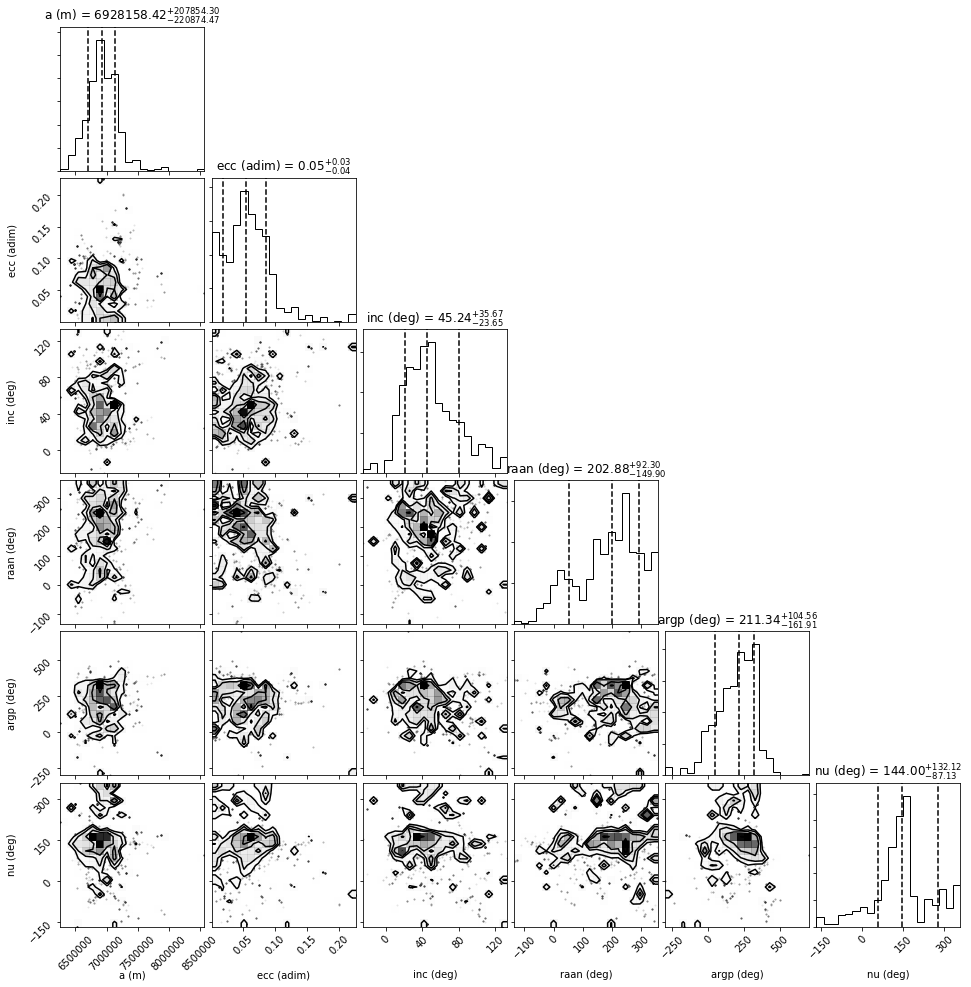

In [53]:
fig = corner.corner(samples, labels=["a (m)", "ecc (adim)", "inc (deg)",
                                     "raan (deg)", "argp (deg)", "nu (deg)"]
                    , show_titles=True
                    , plot_datapoints=True
                    , quantiles=[0.16,0.5, 0.84])

In [39]:
sampler.chain.shape

(100, 50, 6)

In [40]:
prob = sampler.lnprobability.ravel()

In [41]:
prob

array([-11162.92824757, -11162.92824757, -11162.92824757, ...,
        -1952.68176346,  -1952.68176346,  -1952.68176346])

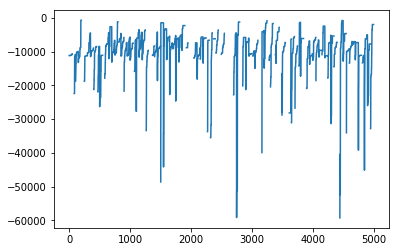

In [42]:
plt.plot(prob)

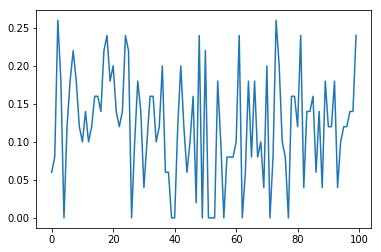

In [43]:
plt.plot(sampler.acceptance_fraction)

In [80]:
a_m  = samples[:,0].mean() 
ecc_m  = samples[:,1].mean() 
inc_m  = samples[:,2].mean() 
raan_m = samples[:,3].mean() 
argp_m = samples[:,4].mean() 
nu_m = samples[:,5].mean() 

In [82]:
print("a\t",(a_m * u.m).to(u.km))
print("ecc\t", (ecc_m*u.one))
print("inc\t", (inc_m*u.deg))
print("raan\t", (raan_m*u.deg))
print("argp\t", (argp_m*u.deg))
print("nu\t", (nu_m*u.deg))


a	 6935.115315969192 km
ecc	 0.05718895244184093
inc	 49.45801909570281 deg
raan	 185.82576497250287 deg
argp	 189.50804684556374 deg
nu	 145.63343561933934 deg
